# Usage

At first a goal model is defined by providing its ODE.\
Thereafter the VariableInterpreter class is used to specifie the needed fitting variables and extract the identifiers from the equation.\
Finally the TraceGenerator class is used to compute the needed goal traces for the Loihi Fitter class.\
The Fitter class will find the best parameters for the voltage and synaptic decay constants on Loihi.

### Imports

In [1]:
from fitter.variable_interpreter_development import *
from fitter.trace_generator_development import *
from fitter.loihi_fitter_development import *
import numpy as np
import time
import matplotlib.pyplot as plt
rcParams['font.family'] = 'CMU Sans Serif'
rcParams['font.size'] = 14
rcParams['font.weight'] = 'normal'
rcParams['text.color'] = '#000000'
rcParams['axes.edgecolor'] = '#000000'
rcParams['xtick.color'] = '#000000'
rcParams['ytick.color'] = '#000000'
rcParams['axes.axisbelow'] = True
rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = ':'
rcParams['grid.linewidth'] = 0.5
rcParams['grid.color'] = '#000000'
rcParams['legend.fancybox'] = True
rcParams['legend.framealpha'] = 0.75
rcParams['patch.linewidth'] = 0
rcParams["legend.loc"]  = 'center right'

script_start_time = time.time()

## Definition of the goal model

In [2]:
neuronEquation = '''
dv/dt  = (ge+gi-(v-El))/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
'''

## Extracting and specifying necessary variables

In [3]:
# Create variable interpreter
variable_interpreter = VariableInterpreter(neuronEquation)

# Print identifiers
print('Please specify the following identifiers by filling the template\n')
print('identifiers = {')
for identi in list(variable_interpreter.get_identifier_names()):
    print("'"+str(identi)+"': (value, unit),")
print('}')


Please specify the following identifiers by filling the template

identifiers = {
'taum': (value, unit),
'El': (value, unit),
'taue': (value, unit),
'taui': (value, unit),
}


In [4]:
# model specific identifiers
identifiers = {'El': (-10, mV),
               'taue' : (4, ms),
               'taui'   : (13, ms),
               'taum'  : (12, ms)}

# Essential variables
output_v= ('v', mV)   # the output variable, usually the soma voltage
input_v = ('ge', mV)  # the input variable, here the input will be added
synaps_v= ('ge', mV)  # the variable describing the synaptic behaviour
rest_var= 'El'        # Name of the resting variable
thresh  = (32, mV)    # the firing threshold of the neuron
weight  = (64, mV)    # the weight of the induced stimulus, should be positive
dt      = (1, ms)     # the runtime precision, should be 1, if < 1 fitting result might be diminished due to small decay values
runtime = (100, ms)   # the runtime of the simulation, in this time the neuronal voltage should be decaying back to zero again

# Assign
variable_interpreter.assign_essential_variables(input_v, output_v, synaps_v, rest_var, thresh, weight, dt, runtime)
variable_interpreter.set_identifiers(identifiers)

## Generate and show goal traces

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]


Starting simulation at t=0. s for a duration of 100. ms
100. ms (100%) simulated in < 1s


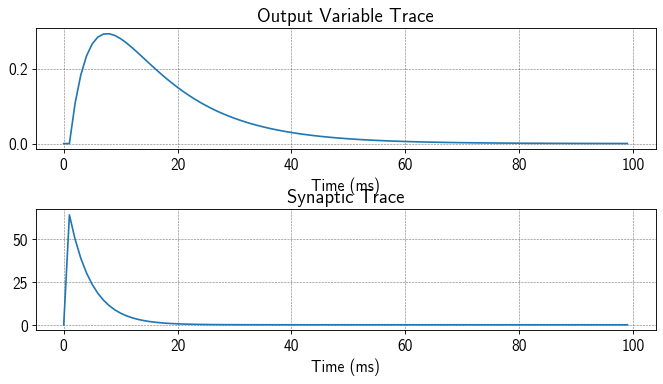

In [5]:
# Make traces
trace_generator = TraceGenerator(variable_interpreter)

s_time = time.time()
trace_generator.generate_traces()
e_time = time.time()
script_generate_traces_time = e_time-s_time

#------------------------------------------------
#    Plotting
#------------------------------------------------
fig = plt.figure(figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace= 0.25, hspace= 0.5)

axA = plt.subplot(2,1,1)
plt.title('Output Variable Trace')
plt.xlabel('Time (ms)')
plot(trace_generator.get_trace())

axB = plt.subplot(2,1,2)
plt.title('Synaptic Trace')
plt.xlabel('Time (ms)')
plt.plot(np.arange(0,runtime[0], dt[0]), trace_generator.get_synaptic_trace())
plt.show()


## Loihi fitting

In [6]:
# Fit Loihi
loihi_fitter = LoihiFitter(trace_generator)

s_time = time.time()
loihi_fitter.fit_model()
loihi_fitter.fit_thres_weight()
e_time = time.time()
script_fit_model_time = e_time-s_time

# Make mantissa table (this can take a long time)
s_time = time.time()
loihi_fitter.fit_mantissa_table()
e_time = time.time()
script_fit_mantissa_table_time = e_time-s_time

## Plot the result

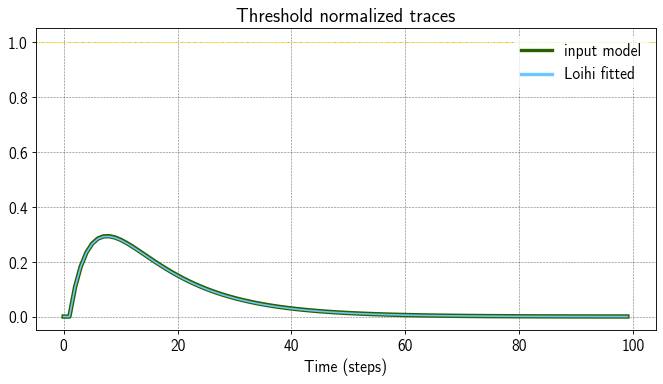

Fitted Loihi parameters
v_decay: 327
I_decay: 906
threshold_mant: 522
weight_mant: 56
weight_exp: 0

Threshold Table
      0      -8      -7      -6      -5      -4      -3      -2      -1       0       1       2       3       4       5       6       7
----------------------------------------------------------------------------------------------------------------------------------------
      0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0
      1       0       0       0       0       0       0       0       0       8      18      36      73     148     297     594    1189
      2       0       0       0       0       0       0       0       8      18      36      73     148     297     594    1189    2379
      3       0       0       0       0       0       0       0       8      27      55     111     222     445     892    1784    3569
      4       0       0       0       0       0       0       8   

In [14]:
fig = plt.figure(figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace= 0.25, hspace= 0.5)

axA = plt.subplot(1,1,1)
plt.title('Threshold normalized traces')
plt.xlabel('Time (steps)')
b_trace = trace_generator.get_trace()
l_trace = loihi_fitter.get_trace()
plt.plot(b_trace, label='input model', color='#2A5F00', linewidth=4)
plt.plot(l_trace, label='Loihi fitted', color ='#6AC7FF')
axhline(y=1, linewidth=1, ls='--', color='#FFE549')
# make a legend
leg = plt.legend(loc='upper right')
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3)
plt.show()

print('Fitted Loihi parameters')
print('=======================')
print(loihi_fitter)

print()
print('Threshold Table')
print('=======================')
loihi_fitter.print_threshold_table()

## Script runtime summary

In [8]:
script_end_time = time.time()
script_runtime = script_end_time - script_start_time
print('overall runtime: ',script_runtime)
print('generate traces: ', script_generate_traces_time, ' %time: ', script_generate_traces_time/script_runtime)
print('fit model:\t ', script_fit_model_time, ' %time: ', script_fit_model_time/script_runtime)
print('fit mant_table:\t ', script_fit_mantissa_table_time, ' %time: ', script_fit_mantissa_table_time/script_runtime)

overall runtime:  4.054447174072266
generate traces:  2.04559326171875  %time:  0.5045307470769601
fit model:	  0.4095485210418701  %time:  0.10101217341315652
fit mant_table:	  0.8809370994567871  %time:  0.2172767486256279
